# Demo: Control of wheel angle with partial state feedback

#### Import modules and configure the notebook.

In [1]:
# These are standard modules
import time
import numpy as np
import sympy as sym
from scipy.signal import place_poles
from scipy import linalg
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Markdown

# This is a custom interface to the pybullet simulator
import ae353_wheel_sensors

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

pybullet build time: Oct 28 2022 16:21:09


#### Choose parameter values

The equation of motion is

$$c_1 \ddot{q} = \tau - c_2\sin q$$

where

* $q$ is the wheel angle
* $\tau$ is the wheel torque, i.e., the torque applied to the wheel by a motor on the ground

and where the values of $c_1$ and $c_2$ are given as follows:

In [2]:
# Values of c1 and c2 for the example (do not change)
c1 = 1.0
c2 = 2.0

# Values of other parameters that are given
g = 9.81 # <-- acceleration of gravity
r = 0.35 # <-- distance from wheel axis to marker (i.e., to the mass)

# Values of other parameters that correspond to the coefficients c1 and c2 that we chose
m = c2 / (g * r)   # <-- set in code
J = c1 - m * r**2  # <-- set in URDF
print(f'm = {m}\nJ = {J}')

m = 0.582495995340032
J = 0.928644240570846


#### Set up simulations

Create an instance of the `Simulator` class with particular values of `roll` and `mass`.

In [3]:
simulator = ae353_wheel_sensors.Simulator(
    display=True,
    roll=(np.pi / 2),
    mass=m,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


#### Define functions to plot results

This function plots results in terms of nonlinear states and inputs.

In [4]:
def show_results(data, q_e, v_e, tau_e):
    t = data['t']
    q = data['wheel_angle']
    v = data['wheel_velocity']
    tau = data['wheel_torque']
    tau_cmd = data['wheel_torque_command']
    q_meas = data['wheel_angle_measurement']
    xhat = data['xhat']
    q_est = xhat[:, 0] + q_e
    v_est = xhat[:, 1] + v_e

    fig, (ax_q, ax_v, ax_tau) = plt.subplots(
        3, 1, figsize=(10, 8), sharex=True,
    )

    ax_q.plot(t, q, label=r'$q$', linewidth=4)
    ax_q.plot(t, q_est, '--', label=r'$q$ (estimated)', linewidth=4)
    ax_q.plot(t, q_meas, '.', markersize=3, label=r'$q$ (measured)')
    ax_q.plot(t, q_e * np.ones_like(t), ':', label=r'$q_e$', linewidth=3, color='C3')
    ax_v.plot(t, v, label=r'$v$', linewidth=4)
    ax_v.plot(t, v_est, '--', label=r'$v$ (estimated)', linewidth=4)
    ax_v.plot(t, v_e * np.ones_like(t), ':', label=r'$v_e$', linewidth=3, color='C3')
    ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
    ax_tau.plot(t, tau_cmd, '-.', label=r'$\tau$ (command)', linewidth=3, color='C6')
    tau_max = np.ones_like(t) * simulator.tau_max
    ax_tau.plot(t, tau_max,
                '--', label=r'$\tau$ (max)', linewidth=2, color='C2', zorder=0)
    ax_tau.plot(t, - tau_max,
                '--', linewidth=2, color='C2', zorder=0)

    ax_q.grid()
    ax_q.legend(fontsize=16, ncol=4, loc='upper right')
    ax_q.tick_params(labelsize=14)
    ax_q.set_ylim(q_e - 0.5, q_e + 0.5)

    ax_v.grid()
    ax_v.legend(fontsize=16, ncol=3, loc='upper right')
    ax_v.tick_params(labelsize=14)
    ax_v.set_ylim(v_e - 1., v_e + 1.)

    ax_tau.grid()
    ax_tau.legend(fontsize=16, ncol=3, loc='upper right')
    ax_tau.tick_params(labelsize=14)
    ax_tau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

    ax_tau.set_xlabel('time (s)', fontsize=20)
    ax_tau.set_xlim([data['t'][0], data['t'][-1]])

    fig.tight_layout()
    plt.show()

This function plots results in terms of linear states and inputs.

In [5]:
def show_results_xuy(data, q_e, v_e, tau_e):
    t = data['t']
    q = data['wheel_angle']
    v = data['wheel_velocity']
    tau = data['wheel_torque']
    tau_cmd = data['wheel_torque_command']
    q_meas = data['wheel_angle_measurement']
    xhat = data['xhat']
    x1 = q - q_e
    x2 = v - v_e
    u1 = tau - tau_e
    u1_cmd = tau_cmd - tau_e
    y1 = q_meas - q_e
    
    fig, (ax_x1, ax_x2, ax_u1) = plt.subplots(
        3, 1, figsize=(10, 8), sharex=True,
    )

    ax_x1.plot(t, x1, label=r'$x_1$', linewidth=4)
    ax_x1.plot(t, xhat[:, 0], '--', label=r'$x_1$ (estimated)', linewidth=4)
    ax_x1.plot(t, y1, '.', markersize=3, label=r'$y_1$')
    ax_x2.plot(t, x2, label=r'$x_2$', linewidth=4)
    ax_x2.plot(t, xhat[:, 1], '--', label=r'$x_2$ (estimated)', linewidth=4)
    ax_u1.plot(t, u1, label=r'$u_1$', linewidth=4)
    ax_u1.plot(t, u1_cmd, '-.', label=r'$u_1$ (command)', linewidth=3, color='C6')
    tau_max = np.ones_like(t) * simulator.tau_max
    ax_u1.plot(t, tau_max - tau_e,
               '--', label=r'$u_1$ (max)', linewidth=2, color='C2', zorder=0)
    ax_u1.plot(t, - tau_max - tau_e,
               '--', linewidth=2, color='C2', zorder=0)
            
    ax_x1.grid()
    ax_x1.legend(fontsize=16, ncol=3, loc='upper right')
    ax_x1.tick_params(labelsize=14)
    ax_x1.set_ylim(-0.5, 0.5)
        
    ax_x2.grid()
    ax_x2.legend(fontsize=16, ncol=2, loc='upper right')
    ax_x2.tick_params(labelsize=14)
    ax_x2.set_ylim(-1., 1.)
    
    ax_u1.grid()
    ax_u1.legend(fontsize=16, ncol=3, loc='upper right')
    ax_u1.tick_params(labelsize=14)
    ax_u1.set_ylim(tau_e + -1.2 * simulator.tau_max, tau_e + 1.2 * simulator.tau_max)
    
    ax_u1.set_xlabel('time (s)', fontsize=20)
    ax_u1.set_xlim([data['t'][0], data['t'][-1]])
    
    fig.tight_layout()
    plt.show()

#### Do control design

Derive state-space model.

In [6]:
# Define symbolic variables
q, v, tau = sym.symbols('q, v, tau')

# Define ODEs
f = sym.Matrix([
    v,
    (tau - c2 * sym.sin(q)) / c1,
])

# Convert floats to rationals
f = sym.nsimplify(f, rational=True)

# Choose equilibrium point
(q_e, v_e, tau_e) = (np.pi, 0., 0.)

# Linearize
A_num = sym.lambdify([q, v, tau], f.jacobian([q, v]))
A = A_num(q_e, v_e, tau_e).astype(float)
B_num = sym.lambdify([q, v, tau], f.jacobian([tau]))
B = B_num(q_e, v_e, tau_e).astype(float)

# Show result
print(f'A =\n{A}\n\nB =\n{B}')

A =
[[0. 1.]
 [2. 0.]]

B =
[[0.]
 [1.]]


Verify the system is controllable.

In [7]:
W_c = np.block([B, A @ B])
print(f'rank(W_c) = {np.linalg.matrix_rank(W_c)}')

rank(W_c) = 2


Design controller by eigenvalue placement.

In [8]:
K = signal.place_poles(A, B, [-2., -5.]).gain_matrix
print(f'K =\n{K}')

K =
[[12.  7.]]


#### Do observer design

Derive state-space model. In particular, given a nonlinear model

$$o = g\left(\begin{bmatrix} q \\ v \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix}\right) = \begin{bmatrix} q \end{bmatrix}$$

of sensor measurements, linearize the function $g$ about the equilibrium point $q_e, v_e, \tau_e$ to produce a state-space model

$$y = Cx + Du$$

where

$$
\begin{aligned}
y
&= o - g\left(\begin{bmatrix} q \\ v \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix}\right) \\
&= \begin{bmatrix} q \end{bmatrix} - \begin{bmatrix} q_e \end{bmatrix} \\
&= \begin{bmatrix} q - q_e \end{bmatrix}
\end{aligned}
$$

and

$$
C = \frac{\partial g}{\partial \begin{bmatrix} q \\ v \end{bmatrix}}\Biggr\rvert_{\left(\begin{bmatrix} q_e \\ v_e \end{bmatrix}, \begin{bmatrix} \tau_e \end{bmatrix}\right)}
\qquad\qquad
D = \frac{\partial g}{\partial \begin{bmatrix} \tau \end{bmatrix}}\Biggr\rvert_{\left(\begin{bmatrix} q_e \\ v_e \end{bmatrix}, \begin{bmatrix} \tau_e \end{bmatrix}\right)}.
$$

In [9]:
# Define nonlinear model
g = sym.Matrix([q])

# Convert floats to rationals
g = sym.nsimplify(g, rational=True)

# Linearize
C_num = sym.lambdify([q, v, tau], g.jacobian([q, v]))
C = C_num(q_e, v_e, tau_e).astype(float)
D_num = sym.lambdify([q, v, tau], g.jacobian([tau]))
D = D_num(q_e, v_e, tau_e).astype(float)

# Show result
print(f'C =\n{C}\n\nD =\n{D}')

C =
[[1. 0.]]

D =
[[0.]]


Verify the system is observable.

In [10]:
W_o = np.block([[C], [C @ A]])
print(f'rank(W_o) = {np.linalg.matrix_rank(W_o)}')

rank(W_o) = 2


Design observer by eigenvalue placement.

In [11]:
L = signal.place_poles(A.T, C.T, [-4., -6.]).gain_matrix.T
print(L)

[[10.]
 [26.]]


Find closed-loop eigenvalues.

In [12]:
linalg.eigvals(A - L @ C)

array([-6.+0.j, -4.+0.j])

Define a function to solve the continuous-time, infinite-horizon LQR problem.

In [13]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

Design observer by solving an LQR problem.

In [18]:
Qo = 1e3 * np.eye(1)
Ro = 1e3 * np.eye(2)
L = lqr(A.T, C.T, np.linalg.inv(Ro), np.linalg.inv(Qo)).T
print(L)

[[3.07768354]
 [4.23606798]]


Find closed-loop eigenvalues.

Verify that the full, closed-loop system — with both the controller and the observer — is asymptotically stable.

In [19]:
# F = ...
# print(linalg.eigvals(F))

What were the eigenvalues of $A - BK$?

In [20]:
print(linalg.eigvals(A - B @ K))

[-2.+0.j -5.+0.j]


What were the eigenvalues of $A - LC$?

In [21]:
print(linalg.eigvals(A - L @ C))

[-1.90211303+0.j -1.1755705 +0.j]


#### Implement controller and observer

In [22]:
class Controller:
    def __init__(self, A, B, C, K, L, q_e, v_e, tau_e):
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.q_e = q_e
        self.v_e = v_e
        self.tau_e = tau_e
        
        self.dt = 0.01
        
        self.variables_to_log = ['xhat']
    
    def reset(self):
        self.xhat = np.array([
            0.,
            0.,
        ])
    
    def run(self, t, wheel_angle_measurement):
        """
        INPUTS
         t = current time (s)
         wheel_angle_measurement = measured angle of wheel from sensors (rad)
         
        OUTPUTS
         wheel_torque = torque applied to wheel by motor on ground (N m)
        """
        
        # Get input
        u = - self.K @ self.xhat
        
        # Get measured wheel angle (sensors)
        q = wheel_angle_measurement
        
        # Get output
        y = np.array([
            q - self.q_e,
        ])
        
        # Get state estimate
        self.xhat += self.dt * (
            self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)
        )
        
        # Get torque (actuators)
        wheel_torque = u[0] + self.tau_e
        
        return wheel_torque

Test controller.

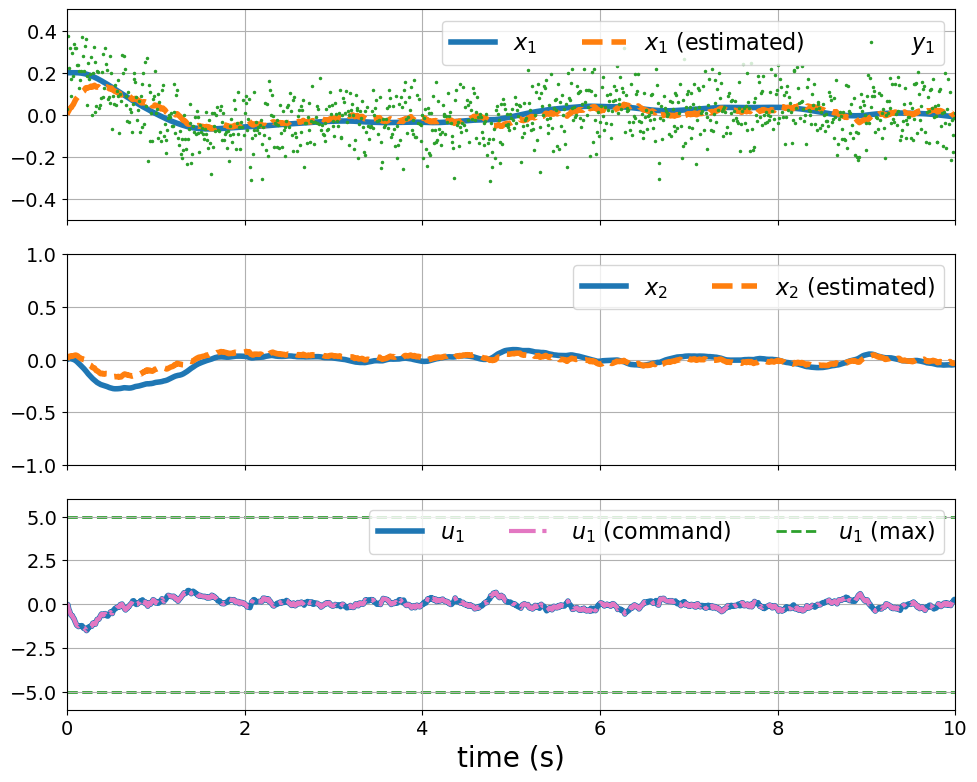

In [23]:
# Create controller
controller = Controller(A, B, C, K, L, q_e, v_e, tau_e)

# Choose initial conditions
(q_i, v_i) = (q_e + 0.2, v_e)

# Reset controller
controller.reset()

# Reset simulator
simulator.reset(
    wheel_angle=q_i,
    wheel_velocity=v_i,
    sensor_noise=0.1,
)

# Reset controller
controller.reset()

# Run simulator
data = simulator.run(
    controller,
    max_time=10.0,
)

# Show results
show_results_xuy(data, q_e, v_e, tau_e)

Example of how to compute RMSE in the state

In [31]:
np.sqrt( np.mean( (data['wheel_angle'] - q_e)**2 ) )

0.0545162499981922

Example of how to compute RMSE in state estimate

In [30]:
np.sqrt(np.mean((data['xhat'][:, 0] - (data['wheel_angle'] - q_e))**2))

0.026980808573363702